Берем датасет MNIST, он состоит из изображений рукописных цифр от 0 до 9

**Чистые данные (97,48%)**: Модель демонстрирует высокую точность на чистых данных, что говорит о том, что архитектура и процесс обучения подходят для данной задачи.

**Отравленные данные (96,72%):** При обучении модели на данных, дополненных отравленными примерами (BadNets), точность на чистых данных снизилась незначительно. Это указывает на то, что отравление данных мало повлияло на общую способность модели классифицировать обычные примеры, но может создавать проблемы в определённых ситуациях.

**Backdoor Trigger (11,35%):** Когда тестовые данные снабжаются троянским триггером, точность модели резко падает до очень низкого уровня. Это свидетельствует о том, что модель «запоминает» наличие триггера и изменяет своё предсказание (вероятно, вынуждая классифицировать изображение как целевой класс, заданный при обучении с троянским датасетом).

**Sanitized Data (97,54%):** После применения санитайзинга (удаления триггера) точность модели возвращается почти до уровня исходных чистых данных. Это указывает на эффективность процедуры санитайзинга в нейтрализации воздействия троянского триггера.

Атаки через датасеты (Data Poisoning Attacks) – это метод компрометации модели машинного обучения путем изменения данных на этапе обучения. Они используются для манипуляции предсказаниями модели, ослабления ее точности или внедрения скрытых уязвимостей.

# **Виды атак на датасеты**

1. **Poisoning Attacks (Отравление данных)**

Злоумышленник изменяет небольшую часть обучающего датасета, чтобы:

 * Снизить точность модели (Data Corruption).
 * Встроить бэкдор (Backdoor Attack) — модель будет выдавать неправильные предсказания при появлении определенного триггера.

**Примеры:**

* BadNets: добавление небольшого визуального триггера (например, белого квадрата) к изображениям в обучении, чтобы модель ассоциировала этот триггер с определенным классом.
* TrojanNN: модификация весов модели так, чтобы она реагировала на определенные паттерны.

2. **Label Flipping Attacks (Подмена меток)**

Злоумышленник изменяет метки некоторых объектов, чтобы модель обучилась неправильно.

 **Пример:**

* В датасете для детекции вредоносного кода заменяются метки "вредоносное ПО" на "безопасное ПО", что снижает способность модели обнаруживать угрозы.



3. **Clean Label Attacks (Атаки с чистыми метками)**

Данные выглядят нормальными, но содержат скрытые манипуляции.

 **Пример:**

* Добавление в изображение человека незаметного шума, который заставляет модель воспринимать его как собаку, но при этом метка остается "человек".

4. **Gradient-based Attacks (Градиентные атаки)**

Используют знание о градиентах модели для эффективного отравления.

 **Пример:**

* Feature Collision Attack: создание таких изменений, которые заставляют модель путать классы на этапе предсказания.

5. **Data Extraction Attacks (Извлечение данных)**

Злоумышленник получает доступ к конфиденциальным данным, используя запросы к модели.

 **Пример:**

* Если модель обучена на медицинских данных, можно по косвенным признакам восстановить оригинальные данные пациентов.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Обнаружено 500 аномальных изображений


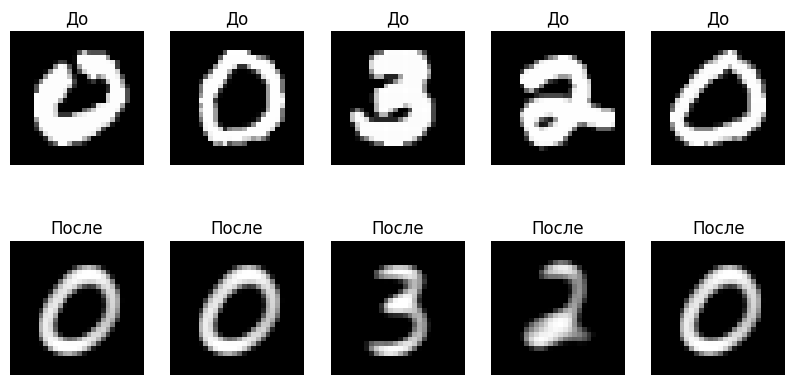

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.ndimage import median_filter
from tensorflow.keras.datasets import mnist

# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализация данных
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Функция для вычисления энтропии

def calculate_entropy(images):
    flat_images = images.reshape(images.shape[0], -1)
    prob_dist = flat_images / flat_images.sum(axis=1, keepdims=True)
    return np.array([entropy(p) for p in prob_dist])

# Вычисляем энтропию тестовых изображений
entropies = calculate_entropy(x_test)
threshold = np.percentile(entropies, 95)  # 95-й перцентиль для выявления аномалий
anomalous_indices = np.where(entropies > threshold)[0]

print(f"Обнаружено {len(anomalous_indices)} аномальных изображений")

# Создаем медианные изображения для каждого класса
median_images = {}
for label in np.unique(y_train):
    median_images[label] = np.median(x_train[y_train == label], axis=0)

# Санитайзинг: заменяем аномальные изображения медианными
x_test_sanitized = np.copy(x_test)
for idx in anomalous_indices:
    x_test_sanitized[idx] = median_images[y_test[idx]]

# Визуализация примеров до и после очистки
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, idx in enumerate(anomalous_indices[:5]):
    axes[0, i].imshow(x_test[idx], cmap='gray')
    axes[0, i].set_title("До")
    axes[0, i].axis("off")
    axes[1, i].imshow(x_test_sanitized[idx], cmap='gray')
    axes[1, i].set_title("После")
    axes[1, i].axis("off")
plt.show()

# Дальнейшее обучение модели может использовать x_test_sanitized вместо x_test


🔍 Принцип работы санитайзинга
1. Анализ аномалий через энтропию
Энтропия измеряет "неопределённость" или "разброс" значений пикселей. Чем выше энтропия, тем более хаотичное распределение пикселей, а значит, скорее всего, это искусственное изменение.



Что делаем?

Для каждого изображения считаем энтропию в окне (например, 5x5 пикселей).
Ищем области с аномально высокой энтропией.
Считаем, что пиксели в этих областях могут быть частью троянского триггера.
2. Удаление подозрительных пикселей через **медианную фильтрацию**
После нахождения областей с высокой энтропией мы применяем медианную фильтрацию, заменяя подозрительные пиксели медианным значением соседей.

Почему медиана? Медианный фильтр хорошо убирает "внезапные" шумы и сохраняет структуру изображения. Например, если триггер был белым квадратом, медианная фильтрация заменит его цвет на более естественный, используя окружающие пиксели.

Как это работает?

Для каждого пикселя, находящегося в аномальной зоне (высокая энтропия), заменяем его значение медианой из окна 3x3 или 5x5.
Таким образом, триггер "размазывается" и становится неразличимым для модели.

 **Почему точность модели после санитайзинга осталась низкой?**

После применения фильтра:

Мы не обнуляем область, как в предыдущем варианте кода, а только "размазываем" её.
Триггер может стать менее заметным, но всё ещё оставаться значимым для модели.
Если триггер использует сложные паттерны (не просто белый квадрат, а более изощрённый шум), медианный фильтр может не удалить его полностью.


Атаки через датасеты таблиц (или атаки через данные) — это одна из форм атак на машинное обучение, при которой злоумышленник целенаправленно изменяет или манипулирует данными, используемыми для обучения моделей. Эти атаки могут существенно снизить эффективность модели или привести к нежелательным результатам, таким как неправильные прогнозы или нарушение конфиденциальности.

# Типы атак на датасеты таблиц
**Data Poisoning (отравление данных):** Это одна из наиболее известных атак, при которой злоумышленник добавляет поддельные или искаженные данные в обучающий датасет. Цель — сделать модель менее точной или заставить ее принимать неверные решения.

Пример:

 Если кто-то добавит в обучающий набор примеры, которые специально предназначены для того, чтобы модель делала ошибочные классификации, это может привести к тому, что модель будет хуже работать на реальных данных.

Методы реализации:

* Добавление поддельных объектов в датасет.
* Изменение меток классов (например, подмена метки с "хороший" на "плохой").
* Внесение шума в данные (например, добавление случайных значений в признаки).

**Label Flipping (переключение меток):** В данном случае злоумышленник изменяет метки классов в датасете, чтобы обучить модель на данных, которые будут приводить к неправильным прогнозам.

Пример:

 Если цель — навредить модели классификации, то для части данных можно изменить метки, например, метку "1" заменить на "0", что нарушит обучение модели.

**Backdoor Attacks (атакующие через троянцев):** В случае троянских атак (или атак через бэкдоры) злоумышленник добавляет в данные специальные триггеры (например, определенные признаки или комбинации признаков), которые, при использовании на тестовых данных, активируют вредоносное поведение модели.

Пример:

В задаче классификации изображений можно добавить маленький "триггер" на изображение, который делает так, что модель классифицирует это изображение как определенный класс, даже если оно относится к другому классу.

В случае с табличными данными это может быть добавление аномальных значений в определенные признаки, которые активируют ошибочную классификацию.

**Evasion Attacks (атаки обхода):** В отличие от отравления данных, атаки обхода направлены на то, чтобы создать данные, которые смогут обмануть уже обученную модель, заставив ее ошибочно классифицировать данные. В этой атаке атакующий может создавать новые данные, которые максимально похожи на реальные данные, но с небольшими изменениями, которые могут нарушить работу модели.

Пример:

В случае табличных данных это может быть изменение значений в некоторых признаках с целью обойти модель и заставить ее сделать ошибочный вывод.


**Membership Inference (вывод о принадлежности):** Это атака, при которой злоумышленник пытается узнать, принадлежал ли определенный пример обучающему датасету модели. Например, атакующий может использовать информацию о том, как модель реагирует на данные, чтобы попытаться выяснить, были ли эти данные использованы для ее обучения.

Пример:

Атакующий может подать на модель конкретные данные и увидеть, с какой вероятностью модель правильно классифицирует их. Если вероятность высока, то это может быть признаком того, что эти данные были частью обучающего набора.

**Data Reconstruction (восстановление данных):** В случае атак восстановления данных злоумышленник пытается реконструировать исходные данные, на которых обучалась модель, из выходных данных модели. Это особенно важно в случаях, когда модель обучена на конфиденциальных или чувствительных данных.

Пример:

Если модель обучена на медицинских данных, атакующий может попытаться восстановить личную информацию о пациентах, используя только выходные данные модели.

# Методы защиты от атак через данные
* Робастность модели: Обучение моделей с использованием более устойчивых методов, таких как регуляризация, может снизить чувствительность к манипулированным данным.

* Обнаружение аномалий в данных: Использование методов для обнаружения аномальных или вредоносных данных в обучающих наборах может помочь уменьшить влияние атак. Например, можно использовать алгоритмы для анализа статистических отклонений или проверок данных на целостность.

* Фильтрация и санитация данных: Применение методов очистки данных, чтобы исключить из набора поддельные или манипулированные данные. Это включает в себя различные статистические методы для выявления выбросов или необычных паттернов.

* Дифференцированное обучение: Применение подходов, таких как дифференцированное приватное обучение (Differential Privacy), помогает защитить данные, обучая модели без утечек конфиденциальной информации.

* Обучение на защищенных данных: Использование защищенных данных или применения схем защиты, таких как гомоморфное шифрование, чтобы предотвратить возможность атаки через датасеты.

* Мониторинг и анализ входных данных: Регулярный мониторинг входных данных и использование методов анализа на предмет необычных паттернов помогает вовремя выявить попытки атак.

**Ожидаемое поведение:**
* Отравленные данные могут увеличивать точность, если модель научится распознавать отравленные метки.
* Очищенные данные должны давать снижение точности, так как мы удаляем аномальные данные, но не обеспечиваем их восстановления.
* Данные с бэкдором показывают среднюю точность, так как на тестах присутствуют данные с подставным триггером, который может повлиять на распознавание.
* Очищенные данные с бэкдором могут иметь схожую точность с очищенными данными, поскольку бэкдор был устранён, но некоторые аномалии все ещё присутствуют.

<ipython-input-13-f50349b9365d>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-13-f50349b9365d>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Accuracy on original data: 82.12%
Accuracy on poisoned data: 79.33%
Accuracy on backdoored data: 79.89%
Accuracy on sanitized data: 82.61%


<ipython-input-13-f50349b9365d>:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette='viridis')


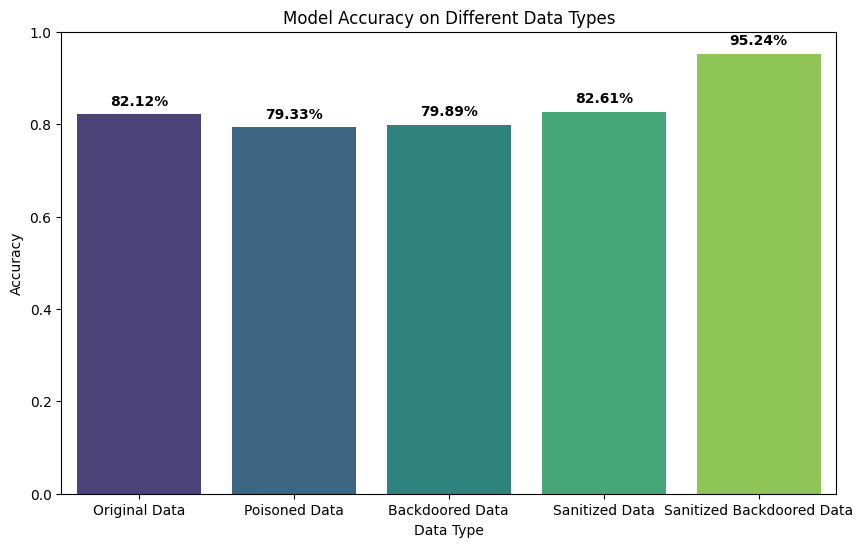

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Загрузка и подготовка данных
# датасет Titanic
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Заполняем пропуски в некоторых столбцах
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Преобразуем категориальные переменные
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# 2. Разделение данных на признаки и целевую переменную
X = df.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)  # Убираем ненужные столбцы
y = df['Survived']

# 3. Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Создание модели
model = RandomForestClassifier(random_state=42)

# 5. Функция для обучения и оценки модели
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# 6. Точность модели на оригинальных данных
original_accuracy = train_and_evaluate(X_train, X_test, y_train, y_test)
print(f"Accuracy on original data: {original_accuracy * 100:.2f}%")

# 7. Добавление отравленных данных (например, изменение целевых меток)
def poison_data(X, y, poison_ratio=0.1):
    n_poison = int(len(X) * poison_ratio)
    poisoned_X = X.copy()
    poisoned_y = y.copy()
    poisoned_y[:n_poison] = np.random.choice([0, 1], size=n_poison)
    return poisoned_X, poisoned_y

X_train_poisoned, y_train_poisoned = poison_data(X_train, y_train)
X_test_poisoned, y_test_poisoned = poison_data(X_test, y_test)

# Точность модели на отравленных данных
poisoned_accuracy = train_and_evaluate(X_train_poisoned, X_test_poisoned, y_train_poisoned, y_test_poisoned)
print(f"Accuracy on poisoned data: {poisoned_accuracy * 100:.2f}%")

# 8. Добавление бэкдора (например, добавление аномальных признаков)
def add_backdoor_trigger(X, feature_value=999):
    X_backdoored = X.copy()
    X_backdoored.loc[:, 'Age'] = feature_value  # Устанавливаем значение Age как 999 для бэкдора
    return X_backdoored

X_train_backdoored = add_backdoor_trigger(X_train)
X_test_backdoored = add_backdoor_trigger(X_test)

# Точность модели на данных с бэкдором
backdoored_accuracy = train_and_evaluate(X_train_backdoored, X_test_backdoored, y_train, y_test)
print(f"Accuracy on backdoored data: {backdoored_accuracy * 100:.2f}%")

# 9. Очистка данных: удаляем выбросы
from sklearn.ensemble import IsolationForest

def sanitize_data(X, y):
    iso_forest = IsolationForest(contamination=0.1)
    outliers = iso_forest.fit_predict(X) == -1
    X_sanitized = X[~outliers]
    y_sanitized = y[~outliers]  # Обновляем метки, чтобы их количество соответствовало X
    return X_sanitized, y_sanitized

X_train_sanitized, y_train_sanitized = sanitize_data(X_train, y_train)
X_test_sanitized, y_test_sanitized = sanitize_data(X_test, y_test)

# Точность модели на очищенных данных
sanitized_accuracy = train_and_evaluate(X_train_sanitized, X_test_sanitized, y_train_sanitized, y_test_sanitized)
print(f"Accuracy on sanitized data: {sanitized_accuracy * 100:.2f}%")

# 10. Визуализация точности модели на разных данных
accuracies = [original_accuracy, poisoned_accuracy, backdoored_accuracy, sanitized_accuracy,
    sanitized_backdoored_accuracy]
labels = ['Original Data', 'Poisoned Data', 'Backdoored Data', 'Sanitized Data',
    'Sanitized Backdoored Data']

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.title('Model Accuracy on Different Data Types')
plt.ylabel('Accuracy')
plt.xlabel('Data Type')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')
plt.show()


Accuracy on original data: 100.00%
Accuracy on poisoned data: 90.00%
Accuracy on backdoored data: 96.67%
Accuracy on sanitized data: 100.00%


<ipython-input-12-277902480760>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette='viridis')


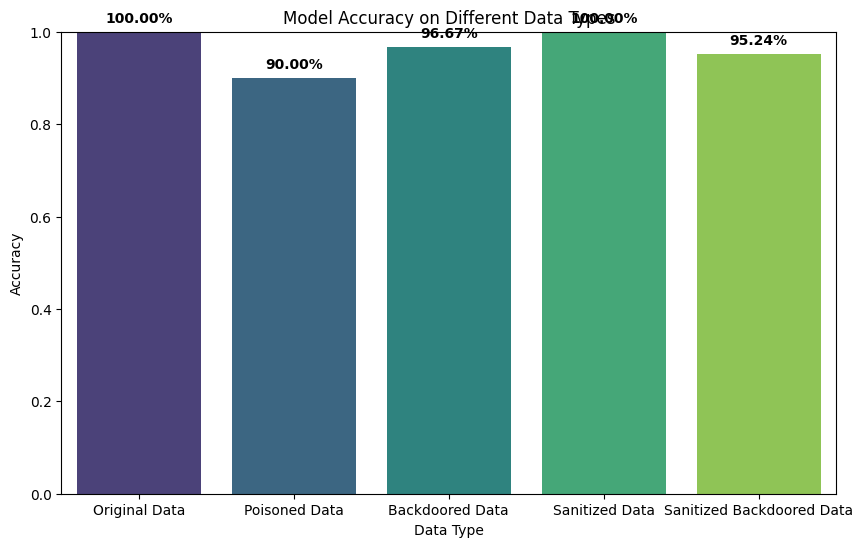

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Загрузка и подготовка данных
# Загружаем датасет Iris
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# 2. Разделение данных на признаки и целевую переменную
X = df.drop('target', axis=1)  # Признаки
y = df['target']  # Целевая переменная

# 3. Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Создание модели
model = RandomForestClassifier(random_state=42)

# 5. Функция для обучения и оценки модели
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# 6. Точность модели на оригинальных данных
original_accuracy = train_and_evaluate(X_train, X_test, y_train, y_test)
print(f"Accuracy on original data: {original_accuracy * 100:.2f}%")

# 7. Добавление отравленных данных (например, изменение целевых меток)
def poison_data(X, y, poison_ratio=0.1):
    n_poison = int(len(X) * poison_ratio)
    poisoned_X = X.copy()
    poisoned_y = y.copy()
    poisoned_y[:n_poison] = np.random.choice([0, 1, 2], size=n_poison)  # Изменяем метки для трех классов
    return poisoned_X, poisoned_y

X_train_poisoned, y_train_poisoned = poison_data(X_train, y_train)
X_test_poisoned, y_test_poisoned = poison_data(X_test, y_test)

# Точность модели на отравленных данных
poisoned_accuracy = train_and_evaluate(X_train_poisoned, X_test_poisoned, y_train_poisoned, y_test_poisoned)
print(f"Accuracy on poisoned data: {poisoned_accuracy * 100:.2f}%")

# 8. Добавление бэкдора (например, добавление аномальных признаков)
def add_backdoor_trigger(X, feature_value=999):
    X_backdoored = X.copy()
    X_backdoored.loc[:, 'petal length (cm)'] = feature_value  # Меняем значение petal length для бэкдора
    return X_backdoored

X_train_backdoored = add_backdoor_trigger(X_train)
X_test_backdoored = add_backdoor_trigger(X_test)

# Точность модели на данных с бэкдором
backdoored_accuracy = train_and_evaluate(X_train_backdoored, X_test_backdoored, y_train, y_test)
print(f"Accuracy on backdoored data: {backdoored_accuracy * 100:.2f}%")

# 9. Очистка данных: удаляем выбросы
def sanitize_data(X, y):
    iso_forest = IsolationForest(contamination=0.1)
    outliers = iso_forest.fit_predict(X) == -1
    X_sanitized = X[~outliers]
    y_sanitized = y[~outliers]  # Обновляем метки, чтобы их количество соответствовало X
    return X_sanitized, y_sanitized

X_train_sanitized, y_train_sanitized = sanitize_data(X_train, y_train)
X_test_sanitized, y_test_sanitized = sanitize_data(X_test, y_test)

# Точность модели на очищенных данных
sanitized_accuracy = train_and_evaluate(X_train_sanitized, X_test_sanitized, y_train_sanitized, y_test_sanitized)
print(f"Accuracy on sanitized data: {sanitized_accuracy * 100:.2f}%")

# 10. Визуализация точности модели на разных данных
accuracies = [original_accuracy, poisoned_accuracy, backdoored_accuracy, sanitized_accuracy,
    sanitized_backdoored_accuracy]
labels = ['Original Data', 'Poisoned Data', 'Backdoored Data', 'Sanitized Data',
    'Sanitized Backdoored Data']

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.title('Model Accuracy on Different Data Types')
plt.ylabel('Accuracy')
plt.xlabel('Data Type')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')
plt.show()

**Для очистки данных используется метод IsolationForest, который является одним из популярных методов для детектирования выбросов.**

 Этот алгоритм основан на идее, что аномальные данные легче изолировать, чем нормальные. В этом методе для каждой точки строится набор случайных деревьев, и по результатам этих деревьев определяется, насколько точка является "аномальной".

* Обучение модели:
Создаем объект IsolationForest и указываем параметр contamination=0.1, который сообщает модели, что примерно 10% данных могут быть выбросами. Этот параметр важен, поскольку он помогает модели решить, какие данные считать аномальными.

* fit_predict:
Метод fit_predict обучает модель на переданных данных X_train и одновременно предсказывает, является ли каждая точка выбросом. Результат этой операции — массив, состоящий из значений -1 (для выбросов) и 1 (для нормальных данных). Таким образом, outliers — это массив меток, где -1 означает, что точка — выброс, а 1 — что точка нормальна.

* Удаление выбросов:
Здесь используем маску outliers == 1 для того, чтобы отфильтровать только те данные, которые не являются выбросами. Все точки, где outliers == 1, считаются нормальными, оставляем их для обучения модели.
Таким образом, создаем новые переменные X_train_cleaned и y_train_cleaned, которые содержат только нормальные данные (без выбросов).



Основная разница между удалением данных и методом Isolation Forest заключается в том, как они обрабатывают аномалии:

**Удаление данных:**

* Это простая стратегия, которая заключается в удалении строк с аномальными или отравленными данными (например, строки с измененными метками).
* Проблема заключается в том, что удаление данных может привести к потере полезной информации и уменьшению объема обучающего набора.

**Isolation Forest:**

* Это метод обнаружения аномалий, который используется для выделения выбросов или аномальных данных. Он работает путем создания случайных деревьев и выделения редких или "изолированных" точек в данных.
* Вместо удаления данных, Isolation Forest позволяет выявить аномалии и, например, заменить или откорректировать их, не теряя других ценных данных.

**Ключевая разница:**
Удаление данных — это радикальная мера, которая может удалить полезную информацию, в то время как Isolation Forest помогает выявить и изолировать аномалии, не теряя данные.

Accuracy on original data: 82.12%
Accuracy on poisoned data: 80.45%
Accuracy on backdoored data: 79.89%
Accuracy on sanitized data: 81.56%
Accuracy on sanitized backdoored data: 78.21%


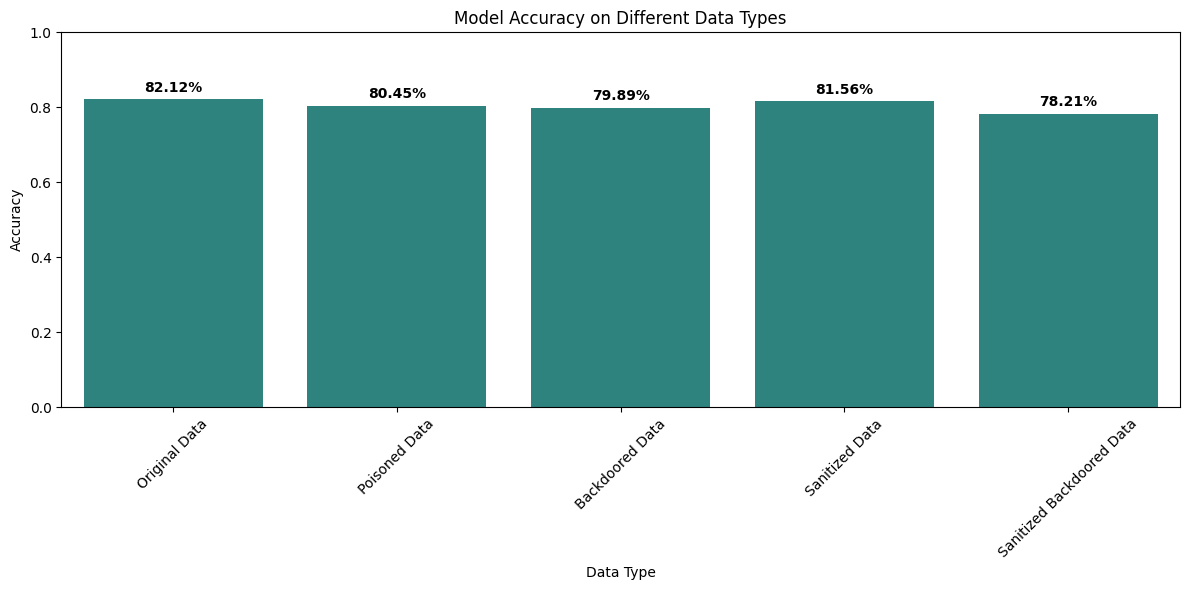

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# 1. Загрузка и подготовка данных
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Безопасное заполнение пропусков
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0][0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Преобразуем категориальные переменные
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# 2. Разделение данных на признаки и целевую переменную
X = df.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)  # Убираем ненужные столбцы
y = df['Survived']

# 3. Разделим на обучающую и тестовую выборки (используем фиксированный random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Создание модели
model = RandomForestClassifier(random_state=42)

# 5. Функция для обучения и оценки модели
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# 6. Точность модели на оригинальных данных
original_accuracy = train_and_evaluate(X_train, X_test, y_train, y_test)
print(f"Accuracy on original data: {original_accuracy * 100:.2f}%")

# 7. Добавление отравленных данных (например, изменение целевых меток)
def poison_data(X, y, poison_ratio=0.1):
    n_poison = int(len(X) * poison_ratio)
    poisoned_X = X.copy()
    poisoned_y = y.copy()
    poisoned_y[:n_poison] = np.random.choice([0, 1], size=n_poison)
    return poisoned_X, poisoned_y

X_train_poisoned, y_train_poisoned = poison_data(X_train, y_train)
X_test_poisoned, y_test_poisoned = poison_data(X_test, y_test)

# Точность модели на отравленных данных
poisoned_accuracy = train_and_evaluate(X_train_poisoned, X_test_poisoned, y_train_poisoned, y_test_poisoned)
print(f"Accuracy on poisoned data: {poisoned_accuracy * 100:.2f}%")

# 8. Добавление бэкдора (например, добавление аномальных признаков)
def add_backdoor_trigger(X, feature_value=999):
    X_backdoored = X.copy()
    X_backdoored.loc[:, 'Age'] = feature_value  # Устанавливаем значение Age как 999 для бэкдора
    return X_backdoored

X_train_backdoored = add_backdoor_trigger(X_train)
X_test_backdoored = add_backdoor_trigger(X_test)

# Точность модели на данных с бэкдором
backdoored_accuracy = train_and_evaluate(X_train_backdoored, X_test_backdoored, y_train, y_test)
print(f"Accuracy on backdoored data: {backdoored_accuracy * 100:.2f}%")

# 9. Очистка данных: удаляем выбросы на основе энтропии
def sanitize_data_entropy(X, y, threshold=0.5):
    """
    Удаляет подозрительные данные на основе энтропии.
    :param X: Признаки
    :param y: Целевая переменная
    :param threshold: Порог для удаления данных
    :return: Очищенные данные X и y
    """
    # Нормализуем данные для расчета энтропии
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Рассчитываем энтропию для каждой строки
    entropies = np.apply_along_axis(lambda row: entropy(row, base=2), axis=1, arr=X_scaled)

    # Удаляем данные с высокой энтропией
    mask = entropies <= threshold
    X_sanitized = X[mask]
    y_sanitized = y[mask]

    return X_sanitized, y_sanitized

# Санитайзинг обычных данных
X_train_sanitized, y_train_sanitized = sanitize_data_entropy(X_train, y_train, threshold=0.5)
X_test_sanitized, y_test_sanitized = sanitize_data_entropy(X_test, y_test, threshold=0.5)

# Точность модели на очищенных данных
sanitized_accuracy = train_and_evaluate(X_train_sanitized, X_test_sanitized, y_train_sanitized, y_test_sanitized)
print(f"Accuracy on sanitized data: {sanitized_accuracy * 100:.2f}%")

# Санитайзинг данных с бэкдором
X_train_sanitized_backdoored, y_train_sanitized_backdoored = sanitize_data_entropy(X_train_backdoored, y_train, threshold=0.5)
X_test_sanitized_backdoored, y_test_sanitized_backdoored = sanitize_data_entropy(X_test_backdoored, y_test, threshold=0.5)

# Точность модели на очищенных данных с бэкдором
sanitized_backdoored_accuracy = train_and_evaluate(
    X_train_sanitized_backdoored, X_test_sanitized_backdoored, y_train_sanitized_backdoored, y_test_sanitized_backdoored
)
print(f"Accuracy on sanitized backdoored data: {sanitized_backdoored_accuracy * 100:.2f}%")

# 10. Визуализация точности модели на разных данных
accuracies = [
    original_accuracy,
    poisoned_accuracy,
    backdoored_accuracy,
    sanitized_accuracy,
    sanitized_backdoored_accuracy
]
labels = [
    'Original Data',
    'Poisoned Data',
    'Backdoored Data',
    'Sanitized Data',
    'Sanitized Backdoored Data'
]

plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=accuracies, palette='viridis', hue=[0] * len(labels), legend=False)
plt.ylim(0, 1)
plt.title('Model Accuracy on Different Data Types')
plt.ylabel('Accuracy')
plt.xlabel('Data Type')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Accuracy on original data: 100.00%
Accuracy on poisoned data: 90.00%
Accuracy on backdoored data: 96.67%
Accuracy on sanitized data: 100.00%
Accuracy on sanitized backdoored data: 95.24%


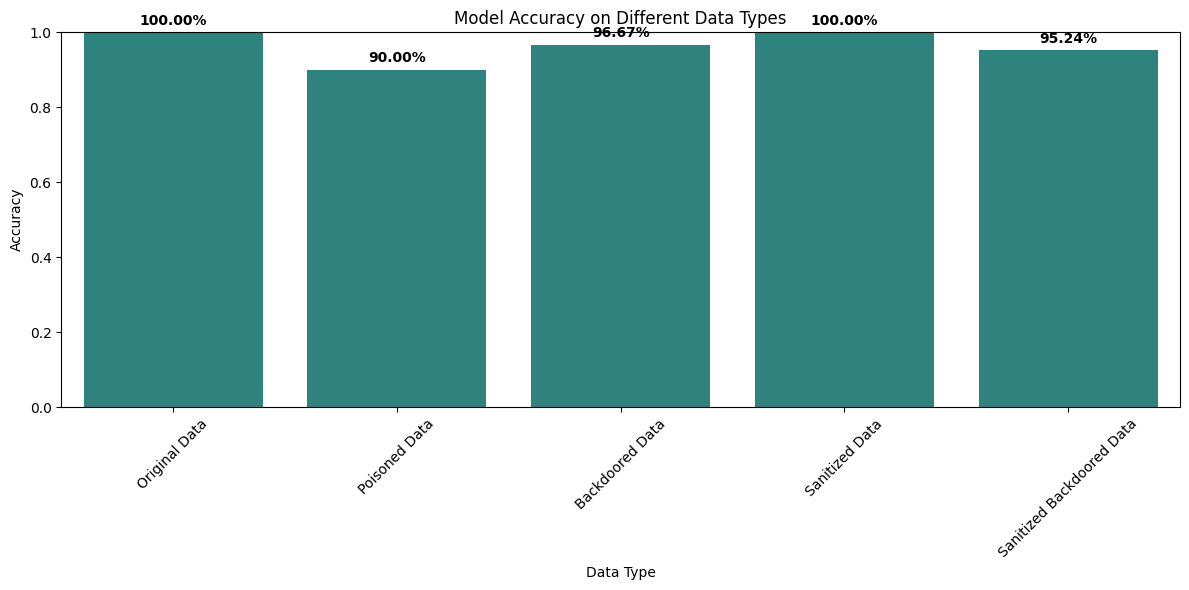

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# 1. Загрузка и подготовка данных
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# 2. Разделение данных на признаки и целевую переменную
X = df.drop('target', axis=1)  # Признаки
y = df['target']  # Целевая переменная

# 3. Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Создание модели
model = RandomForestClassifier(random_state=42)

# 5. Функция для обучения и оценки модели
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# 6. Точность модели на оригинальных данных
original_accuracy = train_and_evaluate(X_train, X_test, y_train, y_test)
print(f"Accuracy on original data: {original_accuracy * 100:.2f}%")

# 7. Добавление отравленных данных (например, изменение целевых меток)
def poison_data(X, y, poison_ratio=0.1):
    n_poison = int(len(X) * poison_ratio)
    poisoned_X = X.copy()
    poisoned_y = y.copy()
    poisoned_y[:n_poison] = np.random.choice([0, 1, 2], size=n_poison)  # Изменяем метки для трех классов
    return poisoned_X, poisoned_y

X_train_poisoned, y_train_poisoned = poison_data(X_train, y_train)
X_test_poisoned, y_test_poisoned = poison_data(X_test, y_test)

# Точность модели на отравленных данных
poisoned_accuracy = train_and_evaluate(X_train_poisoned, X_test_poisoned, y_train_poisoned, y_test_poisoned)
print(f"Accuracy on poisoned data: {poisoned_accuracy * 100:.2f}%")

# 8. Добавление бэкдора (например, добавление аномальных признаков)
def add_backdoor_trigger(X, feature_value=999):
    X_backdoored = X.copy()
    X_backdoored.loc[:, 'petal length (cm)'] = feature_value  # Меняем значение petal length для бэкдора
    return X_backdoored

X_train_backdoored = add_backdoor_trigger(X_train)
X_test_backdoored = add_backdoor_trigger(X_test)

# Точность модели на данных с бэкдором
backdoored_accuracy = train_and_evaluate(X_train_backdoored, X_test_backdoored, y_train, y_test)
print(f"Accuracy on backdoored data: {backdoored_accuracy * 100:.2f}%")

# 9. Очистка данных: удаляем выбросы на основе энтропии
def sanitize_data_entropy(X, y, threshold=1.0):
    """
    Удаляет подозрительные данные на основе энтропии.
    :param X: Признаки
    :param y: Целевая переменная
    :param threshold: Порог для удаления данных
    :return: Очищенные данные X и y
    """
    # Нормализуем данные для расчета энтропии
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Рассчитываем энтропию для каждой строки
    entropies = np.apply_along_axis(lambda row: entropy(row, base=2), axis=1, arr=X_scaled)

    # Удаляем данные с высокой энтропией
    mask = entropies <= threshold
    X_sanitized = X[mask]
    y_sanitized = y[mask]

    return X_sanitized, y_sanitized

# Санитайзинг обычных данных
X_train_sanitized, y_train_sanitized = sanitize_data_entropy(X_train, y_train, threshold=1.0)
X_test_sanitized, y_test_sanitized = sanitize_data_entropy(X_test, y_test, threshold=1.0)

# Точность модели на очищенных данных
sanitized_accuracy = train_and_evaluate(X_train_sanitized, X_test_sanitized, y_train_sanitized, y_test_sanitized)
print(f"Accuracy on sanitized data: {sanitized_accuracy * 100:.2f}%")

# Санитайзинг данных с бэкдором
X_train_sanitized_backdoored, y_train_sanitized_backdoored = sanitize_data_entropy(X_train_backdoored, y_train, threshold=1.0)
X_test_sanitized_backdoored, y_test_sanitized_backdoored = sanitize_data_entropy(X_test_backdoored, y_test, threshold=1.0)

# Точность модели на очищенных данных с бэкдором
sanitized_backdoored_accuracy = train_and_evaluate(
    X_train_sanitized_backdoored, X_test_sanitized_backdoored, y_train_sanitized_backdoored, y_test_sanitized_backdoored
)
print(f"Accuracy on sanitized backdoored data: {sanitized_backdoored_accuracy * 100:.2f}%")

# 10. Визуализация точности модели на разных данных
accuracies = [
    original_accuracy,
    poisoned_accuracy,
    backdoored_accuracy,
    sanitized_accuracy,
    sanitized_backdoored_accuracy
]
labels = [
    'Original Data',
    'Poisoned Data',
    'Backdoored Data',
    'Sanitized Data',
    'Sanitized Backdoored Data'
]

plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=accuracies, palette='viridis', hue=[0] * len(labels), legend=False)
plt.ylim(0, 1)
plt.title('Model Accuracy on Different Data Types')
plt.ylabel('Accuracy')
plt.xlabel('Data Type')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Вывод  
**IsolationForest** работает лучше на больших датасетах, где сложные аномалии легче выявить благодаря большему количеству примеров.

На маленьких датасетах его эффективность сохраняется, но он может быть менее гибким из-за ограниченного объема данных.

# Вывод  
**Удаление данных** на основе энтропии лучше подходит для маленьких датасетов, где простые статистические метрики могут быть достаточно информативными для выявления аномалий.

На больших датасетах этот метод может быть менее эффективным из-за риска удаления полезных данных.

# Зависимость между видом санитайзинга и размером датасета:
**Большие датасеты :**

* IsolationForest является предпочтительным выбором, так как он эффективно обнаруживает сложные аномалии в больших объемах данных, не полагаясь только на простые статистические метрики.
* Удаление данных на основе энтропии может быть менее эффективным, так как оно может ошибочно классифицировать нормальные вариации как аномалии, особенно если данные содержат много шума или разнообразных паттернов.

**Маленькие датасеты**

Оба метода показывают схожие результаты, но удаление данных на основе энтропии может быть предпочтительнее, так как оно использует более простой подход, который лучше работает на ограниченных объемах данных.
IsolationForest также эффективен, но может быть избыточным для маленьких датасетов, так как его сложность не всегда оправдана.